# ML based prediction of condensation promoting or decreasing mutation

Instead of a bio-chemistry driven approach like in [cite], I take a mainly statistical perspective

In [1]:
using Pkg; Pkg.activate("project")
using FASTX
using CSV
using PyPlot
using DataFrames
using ScikitLearn
using Random
using Seaborn
using Statistics
using LinearAlgebra

  Activating project at `~/Documents/Materiale UNI/V anno/Biological Datasets/code/project`


## Loading data and creating a uniform input dataset

First I create csv for reducing and promoting condensation mutations, each row has the protein id in the first column and a variable number of columns for the mutations of the protein (in the format AXB).
I read all wild type fasta and create a vector for the data-points in which each element is a 3-element vector with the wt sequence, the mutated sequence and the annotation of c or d. For the folder with condensing or disolving fasta I reconstruct the original wt using the mutation in the header and add also these data to the vector mentioned above so to have a uniform format for all available data.
(error in P22626,O43781, the given mutations refer to the second isoform, not the main one. For P10636 both isoform 5 and 8 are compatible, i take 5. In P31483 there seems to be an error in the mutation cell, i remove 3185 and the second appearing id. I completely ignore P04150 as none of the wt residues match with any isoform. P29350 to isoform 3. ignore Q9UM73, mentioned mutation position is even longer than the sequence, foggy explanation in the paper. removed E1394K from Q13402, does not appear to exist. substituted Q9UPQ9 with the partner Q9UKV8, the mutations are referred to that. ignored Q96PV0, removed L539K in Q9Y5K6, not present nowhere. P42858 ignored. removed S48E,E17R,Y4R,W334G,W385G,W412G from Q13283)

In [2]:
# READING WILD TYPE .fasta
listdir = readdir("../data/WT")

w_seq = []
w_id = []
for f in listdir
    FASTAReader(open("../data/WT/$f")) do reader
       for record in reader
            push!(w_seq, sequence(record))
            push!(w_id, description(record))
       end
    end
end

# READING CONDENSATION PROMOTING MUTATIONS AND MATCHING WITH CORRESPONDING SEQUENCE
df = CSV.read("../data/promote.txt",DataFrame,header=0,silencewarnings=true)

data = []
for r in eachrow(df)
    i = 2
    id = r[1]
    mut = r[i]
    while typeof(mut) != Missing
        temp = []
        push!(temp, w_seq[w_id .== id][1])
        length(mut) < 3 && error("mutation wrong ", mut)
        mu_position = parse(Int,mut[2:end-1])
        mu_seq = temp[1]
        if mu_seq[mu_position] == mut[1]
            if mut[end] != 'X'
                first = mu_seq[1:mu_position-1]
                last = mu_seq[mu_position+1:end]
                mu_seq = "$first$(mut[end])$last"
            else
                mu_seq = mu_seq[1:mu_position-1]
            end
        else
            println(mu_seq[mu_position]," ",mut[1]," ",id," ",mu_position)
            error("mutated sequence and mutation annotations do not match")
        end
        push!(temp, mu_seq)
        push!(temp, 1) # condensate
        push!(data, temp)
        i = i < length(r) ? i + 1 : break
        mut = r[i]
    end
end

# READING CONDENSATION REDUCING MUTATIONS AND MATCHING WITH CORRESPONDING SEQUENCE
df = CSV.read("../data/reduce.txt",DataFrame,header=0,silencewarnings=true)
for r in eachrow(df)
    i = 2
    id = r[1]
    mut = r[i]
    while typeof(mut) != Missing
        temp = []
        push!(temp, w_seq[w_id .== id][1])
        length(mut) < 3 && error("mutation wrong ", mut)
        mu_position = parse(Int,mut[2:end-1])
        mu_seq = temp[1]
        if mu_seq[mu_position] == mut[1]
            if mut[end] != 'X'
                first = mu_seq[1:mu_position-1]
                last = mu_seq[mu_position+1:end]
                mu_seq = "$first$(mut[end])$last"
            else
                mu_seq = mu_seq[1:mu_position-1]
            end
        else
            println(mu_seq[mu_position]," ",mut[1]," ",id," ",mu_position)
            error("mutated sequence and mutation annotations do not match")
        end
        push!(temp, mu_seq)
        push!(temp, -1) # disolve
        push!(data, temp)
        i = i < length(r) ? i + 1 : break
        mut = r[i]
    end
end

listdir = readdir("../data/COND")

_seq = []
_id = []
for f in listdir
    FASTAReader(open("../data/COND/$f")) do reader
       for record in reader
            push!(_seq, sequence(record))
            push!(_id, description(record))
       end
    end
end

for (i,j) in zip(_seq,_id)
    temp = []
    mut = j[findfirst('_',j)+1:end]
    id = j[1:findfirst('_',j)-1]
    if findfirst(x -> x == id, w_id) != nothing
        continue
    end
    mu_position = parse(Int,mut[2:end-1])
    wt = i
    if wt[mu_position] == mut[end]
        if mut[end] != 'X'
            first = wt[1:mu_position-1]
            last = wt[mu_position+1:end]
            wt = "$first$(mut[1])$last"
        else
            wt = ""
            print("wt not reconstructed")
        end
    else
        println(mu_seq[mu_position]," ",mut[1]," ",id," ",mu_position)
        error("mutated sequence and mutation annotations do not match")
    end
    push!(temp, wt)
    length(mut) < 3 && error("mutation wrong ", mut)
    push!(temp, mut)
    push!(temp, 1)
    push!(data, temp)
end

listdir = readdir("../data/DISOLV")

_seq = []
_id = []
for f in listdir
    FASTAReader(open("../data/DISOLV/$f")) do reader
       for record in reader
            push!(_seq, sequence(record))
            push!(_id, description(record))
       end
    end
end

for (i,j) in zip(_seq,_id)
    temp = []
    mut = j[findfirst('_',j)+1:end]
    id = j[1:findfirst('_',j)-1]
    if findfirst(x -> x == id, w_id) != nothing
        continue
    end
    mu_position = parse(Int,mut[2:end-1])
    wt = i
    if wt[mu_position] == mut[end]
        if mut[end] != 'X'
            first = wt[1:mu_position-1]
            last = wt[mu_position+1:end]
            wt = "$first$(mut[1])$last"
        else
            wt = ""
            print("wt not reconstructed")
        end
    else
        println(mu_seq[mu_position]," ",mut[1]," ",id," ",mu_position)
        error("mutated sequence and mutation annotations do not match")
    end
    push!(temp, wt)
    length(mut) < 3 && error("mutation wrong ", mut)
    push!(temp, mut)
    push!(temp, -1)
    push!(data, temp)
end
    

## Preprocessing of data

Here I use the data together with prior knowledge of the physical characteristics of residues to compute some statistics which will be later fed into a ML algorithm. In such a way the whole prediction procedure is only sequence baseed and the information not strictly sequence related is embedded in the code.

### Computing $\Delta S$

In [3]:
amino = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'];

In [4]:
DS = map(data) do d
    p_i = zeros(length(amino))
    p_i = map(p_i,amino) do p,a
        for i in d[1]
            if a == i 
                p += 1 
            end
        end
        p = p / length(d[1])
    end
    p_i = p_i[p_i .> 0]
    S_wt = - sum(p*log(p) for p in p_i)
    p_i = zeros(length(amino))
    p_i = map(p_i,amino) do p,a
        for i in d[2]
            if a == i 
                p += 1 
            end
        end
        p = p / length(d[2])
    end
    p_i = p_i[p_i .> 0]
    S_mu = - sum(p*log(p) for p in p_i)
    S_mu - S_wt
end;

### KL divergence

In [5]:
KL = map(data) do d
    p_i = zeros(length(amino))
    p_i = map(p_i,amino) do p,a
        for i in d[1]
            if a == i 
                p += 1 
            end
        end
        p = p / length(d[1])
    end
    q_i = zeros(length(amino))
    q_i = map(q_i,amino) do p,a
        for i in d[2]
            if a == i 
                p += 1 
            end
        end
        p = p / length(d[2])
    end
    KL_i = map(p_i,q_i) do p,q
        if p == 0
            0
        elseif q == 0
            1e20
        else
            p*log(p/q)
        end
    end
    sum(KL_i)
end;

### Hydrophobicity change

In [6]:
#amino = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
charge = ["NP", "NP", "-", "-", "NP", "NP", "+", "NP", "+", "NP", "NP", "P", "NP", "P", "+", "P", "P", "NP", "NP", "P"];
charge_dict = Dict(zip(amino,charge));

In [7]:
HP = map(data) do d
    temp = 0
    for (w,m) in zip(d[1],d[2])
        if w == m
            continue
        elseif (charge_dict[w] == "NP") && (charge_dict[m] == "P" || charge_dict[m] == "+" || charge_dict[m] == "-")
            temp += 1
        elseif (charge_dict[m] == "NP") && (charge_dict[w] == "P" || charge_dict[w] == "+" || charge_dict[w] == "-")
            temp += 1
        end
    end
    if length(d[1]) > length(d[2])
        temp =  temp + length(d[1]) - length(d[2])
    end
    temp/length(d[2])
end;

### Charge change

In [8]:
CC = map(data) do d
    temp = 0
    for (w,m) in zip(d[1],d[2])
        if w == m 
            continue
        elseif (charge_dict[w] == "NP" || charge_dict[w] == "P") && (charge_dict[m] == "+")
            temp += 1
        elseif (charge_dict[w] == "NP" || charge_dict[w] == "P") && (charge_dict[m] == "-")
            temp -= 1
        elseif (charge_dict[m] == "NP" || charge_dict[m] == "P") && (charge_dict[w] == "+")
            temp -= 1
        elseif (charge_dict[m] == "NP" || charge_dict[m] == "P") && (charge_dict[w] == "-")
            temp += 1
        elseif charge_dict[w] == "+" && charge_dict[m] == "-"
            temp = temp - 2
        elseif charge_dict[m] == "+" && charge_dict[w] == "-"
            temp = temp + 2
        end
    end
    if length(d[1]) > length(d[2])
        for w in d[1][length(d[2])+1:end]
            if charge_dict[w] == "+"
                temp -= 1
            elseif charge_dict[w] == "-"
                temp += 1
            end
        end
    end
    temp/length(d[2])
end;

## Training the model

try gradient boosted tree

In [23]:
@sk_import ensemble: GradientBoostingClassifier
@sk_import model_selection: GridSearchCV
;

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment


Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0


┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore ~/.julia/packages/ScikitLearn/sqLdT/src/Skcore.jl:259


assuming it makes sense to separate mutations happening on the same protein

In [12]:
Y = [i[3] for i in data]
X = Matrix(undef,length(Y),4)
X[:,1] = DS
X[:,2] = KL
X[:,3] = HP
X[:,4] = CC

Random.seed!(12345)
perm = randperm(length(Y))
Y = Y[perm]
X = X[perm,:]

train = Int(trunc(length(Y) * 0.8))
X_train = X[1:train,:]
Y_train = Y[1:train]
X_test = X[train+1:end,:]
Y_test = Y[train+1:end];

### correlation between features

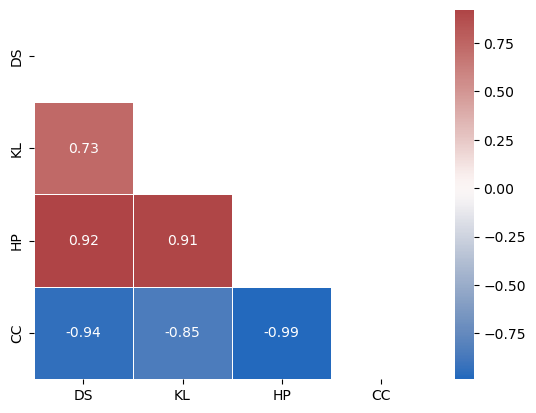

In [13]:
cor_mat = cor(X)
features = ["DS","KL","HP","CC"]
mask = triu(ones(4,4))
heatmap(cor_mat,mask=mask,cmap="vlag",annot=true,linewidths=0.5,center=0,xticklabels=features,yticklabels=features);

is the dataset representative of the actual mutation distribution (i.e. condensation promoting mutations happen less often)?

In [14]:
length(Y[Y .== 1])/length(Y), length(Y[Y .== -1])/length(Y)

(0.17475728155339806, 0.8252427184466019)

In [16]:
BDT = ScikitLearn.GradientBoostingClassifier(random_state=0)
params = Dict("n_estimators" => [100,1000,10000], 
              "learning_rate" => [1.,0.1,0.05,0.01],
              "max_depth" => [1,2,3,5,10,15])

LoadError: UndefVarError: `GradientBoostingClassifier` not defined

In [12]:
models = GridSearchCV(BDT, param_grid=params, cv=10).fit(X_train,Y_train)

PyObject GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': array([1.  , 0.1 , 0.05, 0.01]),
                         'max_depth': array([ 1,  2,  3,  5, 10, 15], dtype=int64),
                         'n_estimators': array([  100,  1000, 10000], dtype=int64)})

In [14]:
models.best_score_, models.best_params_

(0.8540441176470587, Dict{Any, Any}("max_depth" => 1, "learning_rate" => 0.01, "n_estimators" => 100))

In [17]:
models.score(X_test,Y_test)

0.7857142857142857

In [34]:
BDT2 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.01, max_depth = 10, random_state=0).fit(X_train,Y_train)
BDT2.score(X_test,Y_test)

0.8571428571428571

accuracy

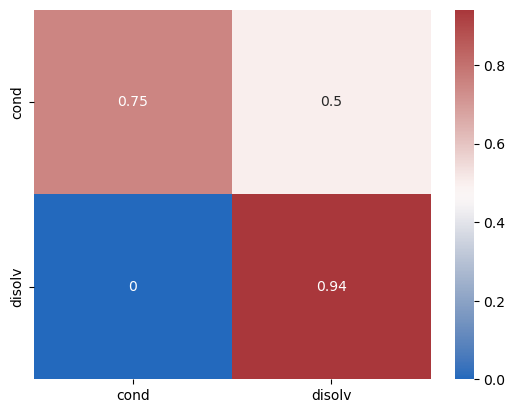

In [35]:
Y_pred = BDT2.predict(X_test)
c_d = length(Y_pred[Y_pred .== 1 .& Y_test .== -1])/length(Y_pred[Y_test .== -1])
d_c = length(Y_pred[Y_pred .== -1 .& Y_test .== 1])/length(Y_pred[Y_test .== 1])
c_c = length(Y_pred[Y_pred .== 1 .& Y_test .== 1])/length(Y_pred[Y_test .== 1])
d_d = length(Y_pred[Y_pred .== -1 .& Y_test .== -1])/length(Y_pred[Y_test .== -1])
acc_mat = [c_c d_c; c_d d_d]
labels = ["cond","disolv"]
heatmap(acc_mat,annot=true,cmap="vlag",xticklabels=labels,yticklabels=labels);

feature importance

In [55]:
BDT2.feature_importances_

4-element Vector{Float64}:
 0.458252021636815
 0.44976057960566884
 0.027176104287582083
 0.0648112944699341